# `nb07`: Expectation-Maximization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.stats import multinomial

In [69]:
from matplotlib.patches import Ellipse

def _plot_cov(ax, cov, pos):
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    
    w, h = 4 * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=w, height=h, 
                    angle=theta, alpha=0.25)
    ax.add_artist(ellip)

def make_plot(x, r=None, mu=None, sigma=None, ll=None):
    fig = plt.figure()
    ax = plt.axes()
    
    if r is None:
        ax.scatter(x[:, 0], x[:, 1], alpha=0.2)
    else:
        clusters = np.argmax(r, axis=1)
        ax.scatter(x[:, 0], x[:, 1], alpha=0.2, c=clusters)
    
    if mu is not None:
        ax.scatter(mu[:, 0], mu[:, 1])
        
    if sigma is not None:
        n_clusters = sigma.shape[0]
        
        for k in range(n_clusters):
            _plot_cov(ax, sigma[k], mu[k])
            
    if ll is not None:
        ax.set(title=r"$ll = {}$".format(ll))
                 
    plt.show()

In [70]:
# Load data
x = np.loadtxt("data/gmm.csv", delimiter=",")

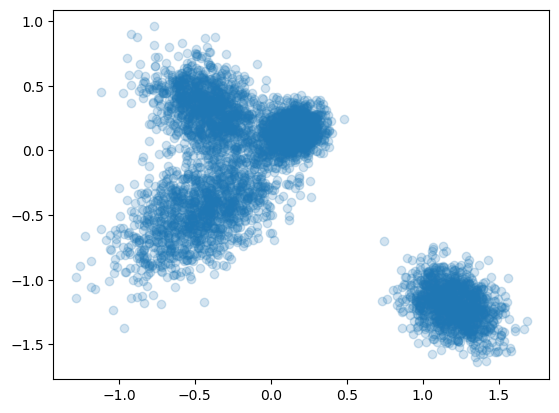

In [71]:
make_plot(x)

# Expectation-Maximization

In [72]:
# Log-likelihood p(x | pi, mu, sigma)   
def ll(x, pi, mu, sigma):
    n_samples = len(x)
    n_clusters = len(pi)
    
    l = np.zeros((n_samples, n_clusters))
    
    for k in range(n_clusters):
        l[:, k] = pi[k] * multivariate_normal(mu[k], sigma[k]).pdf(x)
        
    return np.log(l.sum(axis=1)).mean()

In [73]:
# E-step 
def e_step(x, pi, mu, sigma):
    # Compute the posterior r[i, j] = p(z=j | x_i), for i=1->N, j=1->K
    n_samples = len(x)
    n_clusters = len(pi)

    r = np.zeros((n_samples, n_clusters))

    for k in range(n_clusters):
        r[:, k] = pi[k] * multivariate_normal(mu[k], sigma[k]).pdf(x)

    r = r / np.sum(r, axis=1).reshape(-1, 1)
    
    return r

In [74]:
# M-step
def m_step(x, r):
    # Maximize E_r [ log p(x, z | pi, mu, sigma) ]
    n_samples, n_clusters = r.shape
    
    pi = np.empty(n_clusters)
    mu = np.empty((n_clusters, 2))
    sigma = np.empty((n_clusters, 2, 2))
    
    N = np.sum(r, axis=0)

    for k in range(n_clusters):
        mu[k] = np.sum(r[:, k].reshape(-1, 1) * x, axis=0) / N[k]

    for k in range(n_clusters):
        s = np.array([[0.0, 0.0], [0.0, 0.0]])

        for i in range(n_samples):
            s += r[i, k] * np.outer(x[i] - mu[k], x[i] - mu[k])

        s /= N[k]
        sigma[k] = s
        
    pi = N / n_samples
        
    return pi, mu, sigma

In [75]:
# Initialization
n_samples = len(x)
n_clusters = 4

pi = np.ones(n_clusters) / n_clusters
mu = np.random.randn(n_clusters, 2)
sigma = np.array([[1.0, 0.0], [0.0, 1.0]]) * 0.5
sigma = np.tile(sigma, [n_clusters, 1, 1])

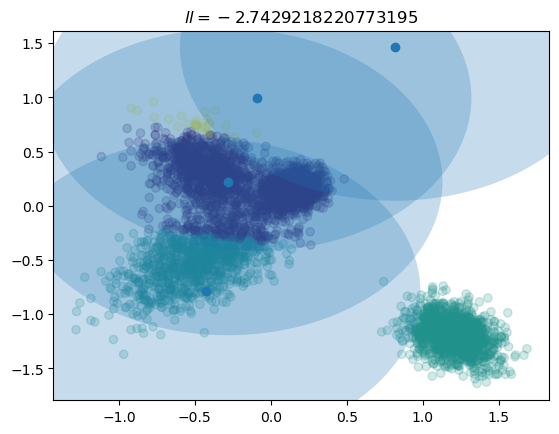

In [76]:
r = e_step(x, pi, mu, sigma)
make_plot(x, r, mu, sigma, ll=ll(x, pi, mu, sigma))

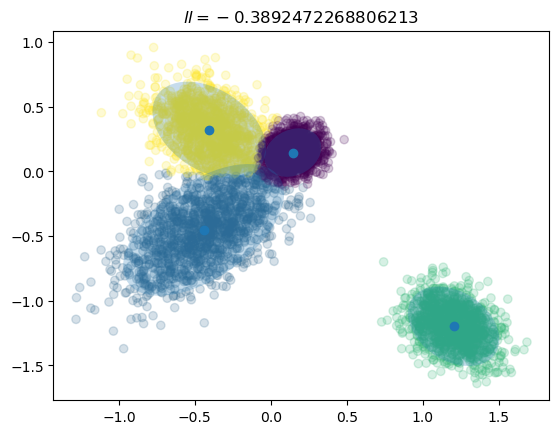

In [101]:
# Iterate manually until convergence
r = e_step(x, pi, mu, sigma)
pi, mu, sigma = m_step(x, r)
make_plot(x, r, mu, sigma, ll=ll(x, pi, mu, sigma))

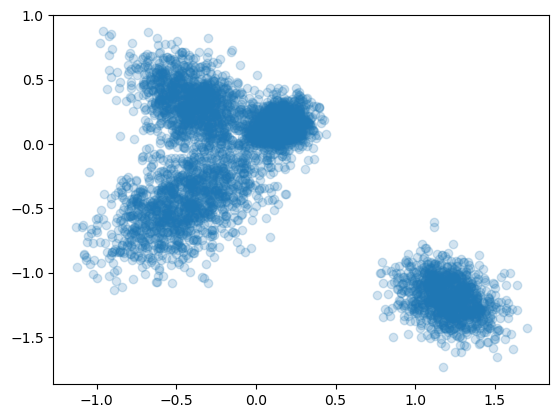

In [102]:
# Simulate new data
def simulate(n_samples, pi, mu, sigma):
    z = np.argmax(multinomial(1, pi).rvs(n_samples), axis=1)
    x = np.zeros((n_samples, 2))
    
    for i in range(n_samples):
        x[i] = multivariate_normal(mu[z[i]], sigma[z[i]]).rvs()
        
    return x

make_plot(simulate(5000, pi, mu, sigma))